**Setup**

In [21]:
# Colab IMDB tuning — run cell by cell (one model per cell)
import os, random
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Reproducibility
os.environ["PYTHONHASHSEED"] = "123"
random.seed(123)
np.random.seed(123)          # <-- correct
tf.random.set_seed(123)

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)


TensorFlow: 2.19.0
NumPy: 2.0.2


**Data prep (IMDB → multi-hot vectors + train/val/test split)**

In [22]:
# ---- Data (multi-hot) ----
num_words = 10_000
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)

def vectorize(seqs, dim=num_words):
    """Convert sequences of word indices into multi-hot vectors."""
    x = np.zeros((len(seqs), dim), dtype="float32")
    for i, s in enumerate(seqs):
        s = np.asarray(s)
        s = s[(s >= 1) & (s < dim)]         # keep valid indices (1..dim-1)
        x[i, s] = 1.0                       # multi-hot: 1 if word appears
    return x

X_train = vectorize(x_train);  X_test = vectorize(x_test)

# Hold out a validation slice from training
val_n = 10_000
X_val, y_val   = X_train[:val_n], y_train[:val_n]
X_part, y_part = X_train[val_n:], y_train[val_n:]

print("Shapes -> part:", X_part.shape, "val:", X_val.shape, "test:", X_test.shape)


Shapes -> part: (15000, 10000) val: (10000, 10000) test: (25000, 10000)


**Helper** **functions:**

In [23]:
def build_model(hidden_layers=2, units=16, activation="relu",
                loss="binary_crossentropy", l2=0.0, dropout=0.0):
    """Create a simple feedforward network for multi-hot IMDB."""
    reg = keras.regularizers.l2(l2) if l2 > 0 else None
    m = keras.Sequential()
    # First hidden layer
    m.add(keras.layers.Dense(units, activation=activation,
                             kernel_regularizer=reg, input_shape=(num_words,)))
    if dropout > 0: m.add(keras.layers.Dropout(dropout))
    # Additional hidden layers
    for _ in range(hidden_layers - 1):
        m.add(keras.layers.Dense(units, activation=activation, kernel_regularizer=reg))
        if dropout > 0: m.add(keras.layers.Dropout(dropout))
    # Output layer
    m.add(keras.layers.Dense(1, activation="sigmoid"))
    m.compile(optimizer="rmsprop", loss=loss, metrics=["accuracy"])
    return m

def train_evaluate(description, *, hidden_layers, units, activation, loss, l2=0.0, dropout=0.0,
                   epochs=20, batch_size=512, patience=2):
    """
    Train one configuration and report best validation accuracy + test accuracy.
    Uses EarlyStopping on val_loss with weight restore to avoid overfitting.
    """
    model = build_model(hidden_layers=hidden_layers, units=units, activation=activation,
                        loss=loss, l2=l2, dropout=dropout)
    es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=patience, restore_best_weights=True)
    hist = model.fit(X_part, y_part,
                     validation_data=(X_val, y_val),
                     epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[es])
    val_acc = float(np.max(hist.history["val_accuracy"]))
    test_acc = float(model.evaluate(X_test, y_test, verbose=0)[1])
    gap = val_acc - test_acc

    print(f"\n=== {description} ===")
    print(f"Best validation accuracy: {val_acc:.4f}")
    print(f"Test accuracy:           {test_acc:.4f}")
    print(f"Validation–Test gap:     {gap:.4f}")

    # Plain-English interpretation of generalization gap
    if gap < -0.005:
        print("Interpretation: Test ≥ Val (no overfitting concern; differences likely random).")
    elif gap <= 0.02:
        print("Interpretation: Small gap → good generalization.")
    elif gap <= 0.05:
        print("Interpretation: Mild overfitting; consider light regularization or fewer parameters.")
    else:
        print("Interpretation: Notable overfitting; prefer stronger regularization or a smaller model.")

    return model, hist, val_acc, test_acc

# We’ll collect results incrementally and compare against the baseline.
rows = []
baseline_val = None


**Baseline**

In [24]:
title = "Baseline — 2×16 ReLU + BCE"
m0, h0, v0, t0 = train_evaluate(
    "Baseline (2 layers × 16 units, ReLU, Binary Crossentropy)",
    hidden_layers=2, units=16, activation="relu", loss="binary_crossentropy",
    l2=0.0, dropout=0.0
)
rows.append(dict(id="E00", description="Baseline (2x16, relu, BCE)",
                 hidden_layers=2, units=16, activation="relu", loss="binary_crossentropy",
                 l2=0.0, dropout=0.0, val_accuracy=round(v0,4), test_accuracy=round(t0,4)))
baseline_val = v0
print(f"\nBaseline saved. (Val = {v0:.4f}, Test = {t0:.4f})")



=== Baseline (2 layers × 16 units, ReLU, Binary Crossentropy) ===
Best validation accuracy: 0.8890
Test accuracy:           0.8810
Validation–Test gap:     0.0080
Interpretation: Small gap → good generalization.

Baseline saved. (Val = 0.8890, Test = 0.8810)


**Shallow (1 layer)**


In [25]:
title = "Shallow (1 layer) — 1×16 ReLU + BCE"
m1, h1, v1, t1 = train_evaluate(
    "Depth ↓ (1 layer × 16 units, ReLU, BCE)",
    hidden_layers=1, units=16, activation="relu", loss="binary_crossentropy"
)
rows.append(dict(id="E01", description="Depth ↓ (1x16)", hidden_layers=1, units=16,
                 activation="relu", loss="binary_crossentropy", l2=0.0, dropout=0.0,
                 val_accuracy=round(v1,4), test_accuracy=round(t1,4)))

delta = v1 - baseline_val
trend = "improved" if delta > 0.005 else ("worse" if delta < -0.005 else "about the same")
print(f"Compared to baseline, validation {trend} by {delta:+.4f}. "
      f"One layer often underfits (less capacity).")



=== Depth ↓ (1 layer × 16 units, ReLU, BCE) ===
Best validation accuracy: 0.8894
Test accuracy:           0.8813
Validation–Test gap:     0.0081
Interpretation: Small gap → good generalization.
Compared to baseline, validation about the same by +0.0004. One layer often underfits (less capacity).


**Deeper (3 layers)**

In [26]:
title = "Deeper (3 layers) — 3×16 ReLU + BCE"
m2, h2, v2, t2 = train_evaluate(
    "Depth ↑ (3 layers × 16 units, ReLU, BCE)",
    hidden_layers=3, units=16, activation="relu", loss="binary_crossentropy"
)
rows.append(dict(id="E02", description="Depth ↑ (3x16)", hidden_layers=3, units=16,
                 activation="relu", loss="binary_crossentropy", l2=0.0, dropout=0.0,
                 val_accuracy=round(v2,4), test_accuracy=round(t2,4)))

delta = v2 - baseline_val
trend = "improved" if delta > 0.005 else ("worse" if delta < -0.005 else "about the same")
print(f"Compared to baseline, validation {trend} by {delta:+.4f}. "
      f"More depth can help but may overfit on multi-hot IMDB; check the gap above.")



=== Depth ↑ (3 layers × 16 units, ReLU, BCE) ===
Best validation accuracy: 0.8882
Test accuracy:           0.8782
Validation–Test gap:     0.0100
Interpretation: Small gap → good generalization.
Compared to baseline, validation about the same by -0.0008. More depth can help but may overfit on multi-hot IMDB; check the gap above.


**Wider (2×32)**

In [27]:
title = "Wider — 2×32 ReLU + BCE"
m3, h3, v3, t3 = train_evaluate(
    "Wider (2 layers × 32 units, ReLU, BCE)",
    hidden_layers=2, units=32, activation="relu", loss="binary_crossentropy"
)
rows.append(dict(id="E03", description="Wider (2x32)", hidden_layers=2, units=32,
                 activation="relu", loss="binary_crossentropy", l2=0.0, dropout=0.0,
                 val_accuracy=round(v3,4), test_accuracy=round(t3,4)))

delta = v3 - baseline_val
trend = "improved" if delta > 0.005 else ("worse" if delta < -0.005 else "about the same")
print(f"Compared to baseline, validation {trend} by {delta:+.4f}. "
      f"A modest width increase often helps a bit without huge overfitting.")



=== Wider (2 layers × 32 units, ReLU, BCE) ===
Best validation accuracy: 0.8898
Test accuracy:           0.8825
Validation–Test gap:     0.0073
Interpretation: Small gap → good generalization.
Compared to baseline, validation about the same by +0.0008. A modest width increase often helps a bit without huge overfitting.


**Wider+ (2×64)**

In [28]:
title = "Wider+ — 2×64 ReLU + BCE"
m4, h4, v4, t4 = train_evaluate(
    "Wider (2 layers × 64 units, ReLU, BCE)",
    hidden_layers=2, units=64, activation="relu", loss="binary_crossentropy"
)
rows.append(dict(id="E04", description="Wider (2x64)", hidden_layers=2, units=64,
                 activation="relu", loss="binary_crossentropy", l2=0.0, dropout=0.0,
                 val_accuracy=round(v4,4), test_accuracy=round(t4,4)))

delta = v4 - baseline_val
trend = "improved" if delta > 0.005 else ("worse" if delta < -0.005 else "about the same")
print(f"Compared to baseline, validation {trend} by {delta:+.4f}. "
      f"Big width can overfit; ensure the gap stays small.")



=== Wider (2 layers × 64 units, ReLU, BCE) ===
Best validation accuracy: 0.8911
Test accuracy:           0.8834
Validation–Test gap:     0.0077
Interpretation: Small gap → good generalization.
Compared to baseline, validation about the same by +0.0021. Big width can overfit; ensure the gap stays small.


**Narrow (2×8)**

In [29]:
title = "Narrow — 2×8 ReLU + BCE"
m5, h5, v5, t5 = train_evaluate(
    "Narrow (2 layers × 8 units, ReLU, BCE)",
    hidden_layers=2, units=8, activation="relu", loss="binary_crossentropy"
)
rows.append(dict(id="E05", description="Narrow (2x8)", hidden_layers=2, units=8,
                 activation="relu", loss="binary_crossentropy", l2=0.0, dropout=0.0,
                 val_accuracy=round(v5,4), test_accuracy=round(t5,4)))

delta = v5 - baseline_val
trend = "improved" if delta > 0.005 else ("worse" if delta < -0.005 else "about the same")
print(f"Compared to baseline, validation {trend} by {delta:+.4f}. "
      f"Too few units typically underfit (capacity too small).")



=== Narrow (2 layers × 8 units, ReLU, BCE) ===
Best validation accuracy: 0.8898
Test accuracy:           0.8804
Validation–Test gap:     0.0094
Interpretation: Small gap → good generalization.
Compared to baseline, validation about the same by +0.0008. Too few units typically underfit (capacity too small).


**Loss change (MSE)**

In [30]:
title = "Loss change (BCE → MSE) — 2×16 ReLU"
m6, h6, v6, t6 = train_evaluate(
    "Loss = Mean Squared Error (2×16, ReLU)",
    hidden_layers=2, units=16, activation="relu", loss="mse"
)
rows.append(dict(id="E06", description="Loss = MSE", hidden_layers=2, units=16,
                 activation="relu", loss="mse", l2=0.0, dropout=0.0,
                 val_accuracy=round(v6,4), test_accuracy=round(t6,4)))

delta = v6 - baseline_val
trend = "improved" if delta > 0.005 else ("worse" if delta < -0.005 else "about the same")
print(f"Compared to baseline, validation {trend} by {delta:+.4f}. "
      f"For binary targets, BCE usually trains better than MSE; expect same or lower accuracy.")



=== Loss = Mean Squared Error (2×16, ReLU) ===
Best validation accuracy: 0.8890
Test accuracy:           0.8810
Validation–Test gap:     0.0080
Interpretation: Small gap → good generalization.
Compared to baseline, validation about the same by +0.0000. For binary targets, BCE usually trains better than MSE; expect same or lower accuracy.


**Activation change (tanh)**

In [31]:
title = "Activation change (ReLU → tanh) — 2×16, BCE"
m7, h7, v7, t7 = train_evaluate(
    "Activation = tanh (2×16, BCE)",
    hidden_layers=2, units=16, activation="tanh", loss="binary_crossentropy"
)
rows.append(dict(id="E07", description="Activation = tanh", hidden_layers=2, units=16,
                 activation="tanh", loss="binary_crossentropy", l2=0.0, dropout=0.0,
                 val_accuracy=round(v7,4), test_accuracy=round(t7,4)))

delta = v7 - baseline_val
trend = "improved" if delta > 0.005 else ("worse" if delta < -0.005 else "about the same")
print(f"Compared to baseline, validation {trend} by {delta:+.4f}. "
      f"tanh can saturate; ReLU often matches or outperforms it here.")



=== Activation = tanh (2×16, BCE) ===
Best validation accuracy: 0.8875
Test accuracy:           0.8814
Validation–Test gap:     0.0061
Interpretation: Small gap → good generalization.
Compared to baseline, validation about the same by -0.0015. tanh can saturate; ReLU often matches or outperforms it here.


**L2 regularization**

In [32]:
title = "L2 (λ = 1e-3) — 2×16 ReLU + BCE"
m8, h8, v8, t8 = train_evaluate(
    "L2 regularization (λ = 0.001) on 2×16 ReLU, BCE",
    hidden_layers=2, units=16, activation="relu", loss="binary_crossentropy", l2=0.001
)
rows.append(dict(id="E08", description="L2 reg (λ=0.001)", hidden_layers=2, units=16,
                 activation="relu", loss="binary_crossentropy", l2=0.001, dropout=0.0,
                 val_accuracy=round(v8,4), test_accuracy=round(t8,4)))

delta = v8 - baseline_val
trend = "improved" if delta > 0.005 else ("worse" if delta < -0.005 else "about the same")
print(f"Compared to baseline, validation {trend} by {delta:+.4f}. "
      f"L2 tends to reduce overfitting; look for a smaller val–test gap.")



=== L2 regularization (λ = 0.001) on 2×16 ReLU, BCE ===
Best validation accuracy: 0.8874
Test accuracy:           0.8804
Validation–Test gap:     0.0070
Interpretation: Small gap → good generalization.
Compared to baseline, validation about the same by -0.0016. L2 tends to reduce overfitting; look for a smaller val–test gap.


**Dropout**

In [33]:
title = "Dropout p = 0.5 — 2×16 ReLU + BCE"
m9, h9, v9, t9 = train_evaluate(
    "Dropout 0.5 on 2×16 ReLU, BCE",
    hidden_layers=2, units=16, activation="relu", loss="binary_crossentropy", dropout=0.5
)
rows.append(dict(id="E09", description="Dropout (0.5)", hidden_layers=2, units=16,
                 activation="relu", loss="binary_crossentropy", l2=0.0, dropout=0.5,
                 val_accuracy=round(v9,4), test_accuracy=round(t9,4)))

delta = v9 - baseline_val
trend = "improved" if delta > 0.005 else ("worse" if delta < -0.005 else "about the same")
print(f"Compared to baseline, validation {trend} by {delta:+.4f}. "
      f"Dropout is a strong regularizer; expect slightly lower val but tighter generalization.")



=== Dropout 0.5 on 2×16 ReLU, BCE ===
Best validation accuracy: 0.8876
Test accuracy:           0.8836
Validation–Test gap:     0.0040
Interpretation: Small gap → good generalization.
Compared to baseline, validation about the same by -0.0014. Dropout is a strong regularizer; expect slightly lower val but tighter generalization.


**RESULTS**


=== Final ranked results (by validation accuracy) ===
    id                 description  hidden_layers  units activation  \
0  E04                Wider (2x64)              2     64       relu   
1  E03                Wider (2x32)              2     32       relu   
2  E05                Narrow (2x8)              2      8       relu   
3  E01              Depth ↓ (1x16)              1     16       relu   
4  E00  Baseline (2x16, relu, BCE)              2     16       relu   
5  E06                  Loss = MSE              2     16       relu   
6  E02              Depth ↑ (3x16)              3     16       relu   
7  E09               Dropout (0.5)              2     16       relu   
8  E07           Activation = tanh              2     16       tanh   
9  E08            L2 reg (λ=0.001)              2     16       relu   

                  loss     l2  dropout  val_accuracy  test_accuracy  
0  binary_crossentropy  0.000      0.0        0.8911         0.8834  
1  binary_crossentropy 

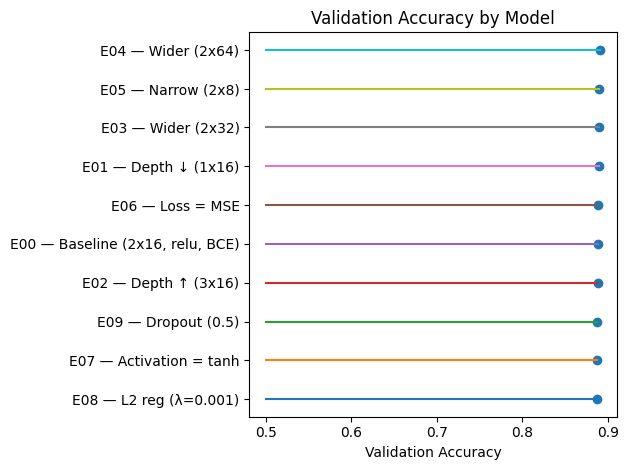


Saved: results.csv and val_accuracy.png


In [34]:
# Assemble final results table
results = pd.DataFrame(rows).sort_values("val_accuracy", ascending=False).reset_index(drop=True)
print("\n=== Final ranked results (by validation accuracy) ===")
print(results)

# Save artifacts for your R Markdown report
results.to_csv("results.csv", index=False)

# Optional: also save to Excel if you prefer
# results.to_excel("results.xlsx", index=False)

# Plot: validation accuracy ranking
plt.figure()
ordered = results.sort_values("val_accuracy")
ylabels = [f'{r.id} — {r.description}' for _, r in ordered.iterrows()]
xvals   = ordered["val_accuracy"].values
plt.scatter(xvals, range(len(xvals)))
for y, x in enumerate(xvals):
    plt.plot([0.5, x], [y, y])  # reference line from 0.5
plt.yticks(range(len(ylabels)), ylabels)
plt.xlabel("Validation Accuracy"); plt.title("Validation Accuracy by Model")
plt.tight_layout(); plt.savefig("val_accuracy.png", dpi=150); plt.show()

print("\nSaved: results.csv and val_accuracy.png")
